# Time Series forecasting with LSTM


## Table of content
1. [Libraries](#libraries)
2. [Read Data](#data)
3. [Feature Engineering](#feature)
4. [Exploratory Data Analysis](#eda)
5. [LSTM model](#lstm)
6. [PREDICTION](#prediction)

### Libraries<a id="libraries"></a>

In [1]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import time
import os

pd.set_option('display.float_format',lambda x: '%.4f' %x)
import seaborn as sns 
sns.set_context('paper',font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from keras.layers import *
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
%matplotlib inline

### Read data<a id="data"></a>

In [2]:
df = pd.read_csv('Superstore.csv', encoding='latin1')

df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2014-103800,1/3/2014,1/7/2014,Standard Class,DP-13000,Darren Powers,Consumer,United States,Houston,...,77095,Central,OFF-PA-10000174,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.4480,2,0.2000,5.5512
1,2,CA-2014-112326,1/4/2014,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-LA-10003223,Office Supplies,Labels,Avery 508,11.7840,3,0.2000,4.2717
2,3,CA-2014-112326,1/4/2014,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-ST-10002743,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.7360,3,0.2000,-64.7748
3,4,CA-2014-112326,1/4/2014,1/8/2014,Standard Class,PO-19195,Phillina Ober,Home Office,United States,Naperville,...,60540,Central,OFF-BI-10004094,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.5400,2,0.8000,-5.4870
4,5,CA-2014-141817,1/5/2014,1/12/2014,Standard Class,MB-18085,Mick Brown,Consumer,United States,Philadelphia,...,19143,East,OFF-AR-10003478,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.5360,3,0.2000,4.8840


### Feature Engineering<a id="feature"></a>

In [3]:
# sắp xếp theo cột 'date_time', chỉ chứa cột 'date_time' và 'Quantity', và các hàng có giá trị NaN trong cột 'Quantity' bị loại bỏ.
# Tạo một cột mới'date_time', trong đó giá trị của mỗi hàng được tạo bằng cách lấy giá trị từ cột 'Order Date' 
df['date_time']=pd.to_datetime(df['Order Date'])
#  Chuyển đổi giá trị trong cột 'Global_active_power' thành kiểu số
df['Quantity']=pd.to_numeric(df['Quantity'],errors='coerce')
df=df.dropna(subset=['Quantity'])

df['date_time']=pd.to_datetime(df['date_time'])
df=df.loc[:,['date_time','Quantity']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)

In [4]:
df

,date_time,Quantity
0,2014-01-03,2
1,2014-01-04,3
2,2014-01-04,3
3,2014-01-04,2
4,2014-01-05,3
...,...,...
9989,2017-12-30,4
9990,2017-12-30,7
9991,2017-12-30,3
9992,2017-12-30,2


In [5]:
#Tạo một cột mới trong DataFrame có tên là 'year', trong đó giá trị của mỗi hàng được lấy từ năm của cột 'date_time'. 
df['year']=df['date_time'].apply(lambda x:x.year)
df['quarter']=df['date_time'].apply(lambda  x:x.quarter)
df['month']=df['date_time'].apply(lambda x:x.month)
df['day']=df['date_time'].apply(lambda x:x.day)
df=df.loc[:,['date_time','Quantity','year','quarter','month','day']]
df.sort_values('date_time',inplace=True,ascending=True)
df=df.reset_index(drop=True)
df['weekday']=df.apply(lambda row : row['date_time'].weekday(),axis=1)
df["weekday"]=(df['weekday']<5).astype(int)


print('Số hàng và cột sau khi loại bỏ các giá trị còn thiếu:',df.shape)
print('Chuỗi thời gian bắt đầu từ:',df['date_time'].min())
print('Chuỗi thời gian kết thúc vào:',df['date_time'].max())

Số hàng và cột sau khi loại bỏ các giá trị còn thiếu: (9994, 7)
Chuỗi thời gian bắt đầu từ: 2014-01-03 00:00:00
Chuỗi thời gian kết thúc vào: 2017-12-30 00:00:00


In [6]:
#kiểm tra xem cột 'Quantity' có tuân theo phân phối Gaussian hay không
stat,p = stats.normaltest(df.Quantity)
print('Statistics=%.3f, p=%.6f' %(stat,p))
alpha=0.05
if p>alpha :
  print('Data looks Gaussian(fail to reject H0)')
else:
  print('Data does not look Gaussian (reject H0)')

Statistics=2148.018, p=0.000000
Data does not look Gaussian (reject H0)


In [7]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  9994 non-null   datetime64[ns]
 1   Quantity   9994 non-null   int64         
 2   year       9994 non-null   int64         
 3   quarter    9994 non-null   int64         
 4   month      9994 non-null   int64         
 5   day        9994 non-null   int64         
 6   weekday    9994 non-null   int32         
dtypes: datetime64[ns](1), int32(1), int64(5)
memory usage: 507.6 KB


,date_time,Quantity,year,quarter,month,day,weekday
0,2014-01-03,2,2014,1,1,3,1
1,2014-01-04,3,2014,1,1,4,0
2,2014-01-04,3,2014,1,1,4,0
3,2014-01-04,2,2014,1,1,4,0
4,2014-01-05,3,2014,1,1,5,0
...,...,...,...,...,...,...,...
9989,2017-12-30,2,2017,4,12,30,0
9990,2017-12-30,4,2017,4,12,30,0
9991,2017-12-30,7,2017,4,12,30,0
9992,2017-12-30,3,2017,4,12,30,0


### Exploratory Data Analysis<a id="eda"></a>

Kurtosis of normal distribution: 1.9902926633129994
Skewness of normal distribution: 1.2783528478702606


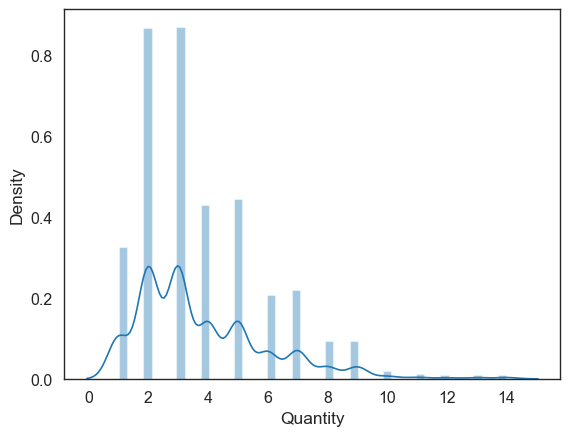

In [8]:
# vẽ đồ thị phân phối của cột 'Quantity' 
sns.distplot(df.Quantity)
print('Kurtosis of normal distribution: {}'.format(stats.kurtosis(df.Quantity)))
print('Skewness of normal distribution: {}'.format(stats.skew(df.Quantity)))

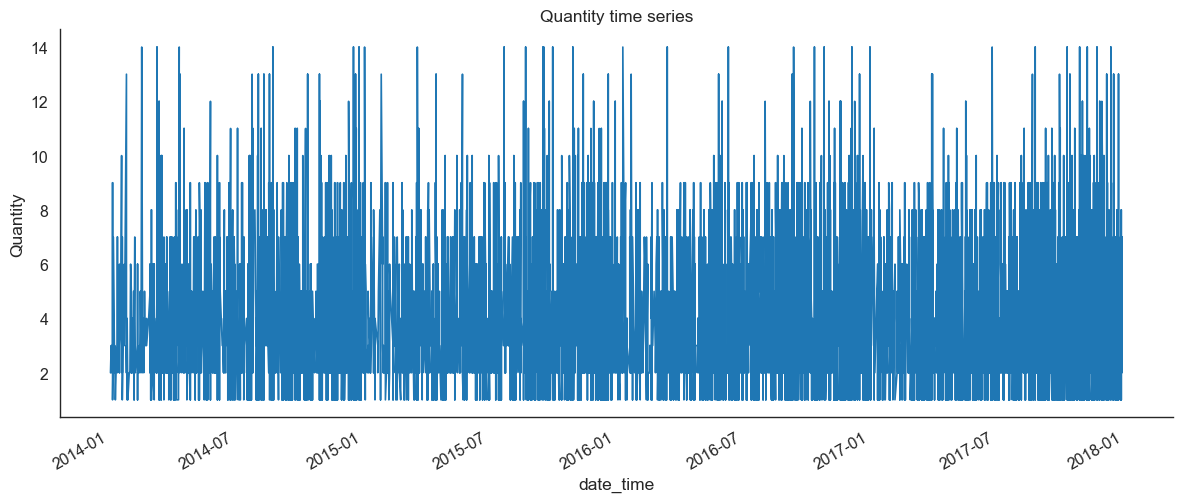

In [9]:
#Tạo một DataFrame mới có tên là df1, chỉ chứa cột 'date_time' và 'Quantity' từ DataFrame ban đầu
df1=df.loc[:,['date_time' ,'Quantity']]
df1.set_index('date_time',inplace=True)
df1.plot(figsize=(12,5))
plt.ylabel('Quantity')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Quantity time series')
sns.despine(top=True)
plt.show()

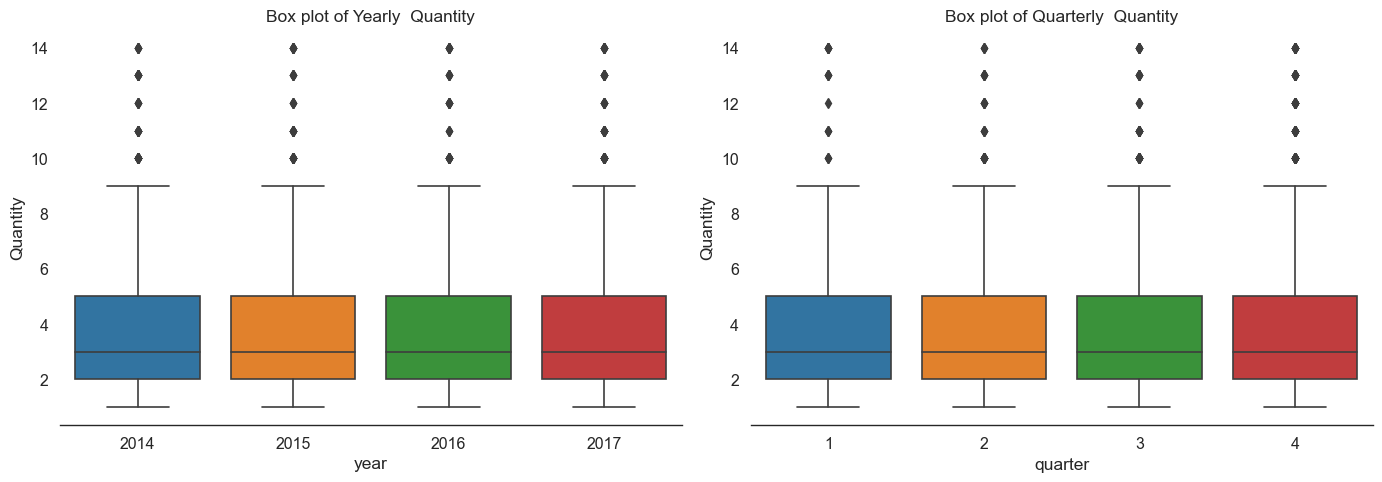

In [10]:
#Vẽ biểu đồ hộp cho cột 'Quantity' theo từng năm
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x='year', y='Quantity',data=df)
plt.xlabel('year')
plt.title('Box plot of Yearly  Quantity')
sns.despine(left=True)
plt.tight_layout()

plt.subplot(1,2,2)
sns.boxplot(x='quarter',y='Quantity',data=df)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly  Quantity')
sns.despine(left=True)
plt.tight_layout()

,count,mean,std,min,25%,50%,75%,max
Quantity,9994.0000,3.7896,2.2251,1.0000,2.0000,3.0000,5.0000,14.0000


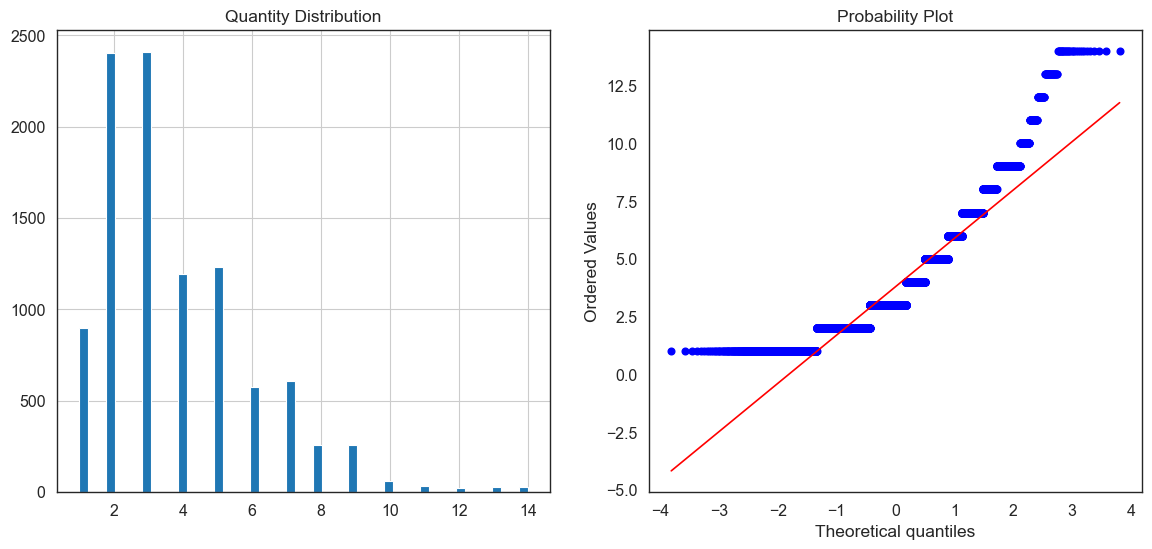

In [11]:
# Kiểm tra phân phối
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
df['Quantity'].hist(bins=50)
plt.title('Quantity Distribution')

plt.subplot(1,2,2)
stats.probplot(df['Quantity'],plot=plt)
df1.describe().T

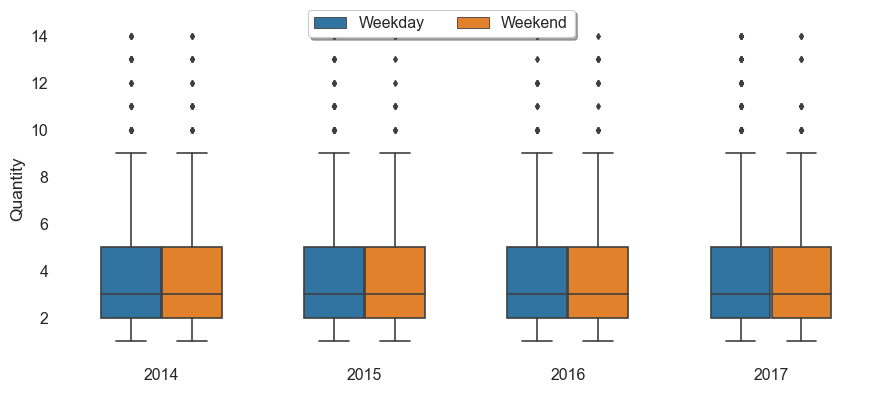

In [12]:
# Check quantity consumption during weekdays and weekends

dic = {0: 'Weekend', 1: 'Weekday'}
df['Day'] = df['weekday'].map(dic)

a = plt.figure(figsize=(9, 4))
plt1 = sns.boxplot(x='year', y='Quantity', hue='Day', width=0.6, fliersize=3, data=df)
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), shadow=True, ncol=2)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.tight_layout()
plt.legend().set_visible(False)

In [13]:
df.head()

,date_time,Quantity,year,quarter,month,day,weekday,Day
0,2014-01-03,2,2014,1,1,3,1,Weekday
1,2014-01-04,3,2014,1,1,4,0,Weekend
2,2014-01-04,3,2014,1,1,4,0,Weekend
3,2014-01-04,2,2014,1,1,4,0,Weekend
4,2014-01-05,3,2014,1,1,5,0,Weekend


### LSTM model<a id="lstm"></a>

In [14]:
train = df[df['date_time'] <= '2016-12-31']
#Tạo một mảng numpy dataset từ cột 'Quantity' của DataFrame df.
dataset_train=train.Quantity.values
dataset_train=dataset_train.astype('float32')
#Thay đổi hình dạng của mảng dataset thành một mảng 2 chiều với một cột và số hàng tự động tính toán.
dataset_train=np.reshape(dataset_train,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset_train=scaler.fit_transform(dataset_train)
test = df[df['date_time'] > '2016-12-31']
#Tạo một mảng numpy dataset từ cột 'Quantity' của DataFrame df.
dataset_test=test.Quantity.values
dataset_test=dataset_test.astype('float32')
#Thay đổi hình dạng của mảng dataset thành một mảng 2 chiều với một cột và số hàng tự động tính toán.
dataset_test=np.reshape(dataset_test,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset_test=scaler.fit_transform(dataset_test)

In [15]:

# Định nghĩa một hàm create_dataset để tạo dữ liệu đầu vào và đầu ra cho mô hình dự đoán chuỗi thời gian. 
# Tham số dataset là mảng dữ liệu, và look_back là số lượng thời điểm quay lại để dự đoán thời điểm hiện tại.
def create_dataset(dataset, look_back=1):
  x,y=[],[]
  for i in range(len(dataset)-look_back-1):
    a=dataset[i:(i+look_back),0]
    x.append(a)
    y.append(dataset[i+look_back,0])
  return np.array(x),np.array(y)

look_back=30

x_train,y_train=create_dataset(dataset_train,look_back)
x_test,y_test=create_dataset(dataset_test,look_back)

# Reshape inputs 
x_train= np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_test=np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))

Mô hình LSTM được xây dựng và huấn luyện trên dữ liệu chuỗi thời gian. Các lớp LSTM và Dense được sử dụng để học và dự đoán giá trị tiếp theo của chuỗi thời gian. Mất mát được tính bằng cách sử dụng hàm mất mát 'mean_squared_error' và quá trình tối ưu hóa được thực hiện bằng thuật toán 'adam'

In [16]:
# Tạo một mô hình tuần tự
model=tf.keras.Sequential()
#Thêm một lớp LSTM vào mô hình với 100 units và kích thước đầu vào là (x_train.shape[1], x_train.shape[2])
model.add(LSTM(200,input_shape=(x_train.shape[1],x_train.shape[2]), activation="relu"))
#Thêm một lớp Dropout với tỷ lệ 0.2 để tránh overfitting.
model.add(Dropout(0.4))
model.add(Dense(36, activation="relu"))
model.add(Dense(32))
model.add(Dense(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#Huấn luyện mô hình trên dữ liệu huấn luyện và kiểm tra
history=model.fit(x_train,y_train, epochs=20, batch_size=100,validation_data=(x_test,y_test),
                  callbacks=[EarlyStopping(monitor='val_loss',patience=10)],verbose=1,shuffle=False)
model.summary()

Epoch 1/20
67/67 [==============================] - 2s 13ms/step - loss: 0.0323 - val_loss: 0.0291
Epoch 2/20
67/67 [==============================] - 0s 6ms/step - loss: 0.0295 - val_loss: 0.0292
Epoch 3/20
67/67 [==============================] - 0s 5ms/step - loss: 0.0295 - val_loss: 0.0292
Epoch 4/20
67/67 [==============================] - 0s 4ms/step - loss: 0.0295 - val_loss: 0.0292
Epoch 5/20
67/67 [==============================] - 0s 4ms/step - loss: 0.0294 - val_loss: 0.0292
Epoch 6/20
67/67 [==============================] - 1s 8ms/step - loss: 0.0294 - val_loss: 0.0291
Epoch 7/20
67/67 [==============================] - 0s 6ms/step - loss: 0.0293 - val_loss: 0.0290
Epoch 8/20
67/67 [==============================] - 0s 5ms/step - loss: 0.0293 - val_loss: 0.0291
Epoch 9/20
67/67 [==============================] - 0s 4ms/step - loss: 0.0293 - val_loss: 0.0291
Epoch 10/20
67/67 [==============================] - 0s 5ms/step - loss: 0.0292 - val_loss: 0.0291
Epoch 11/20
67/67 

### PREDICTION<a id="prediction"></a>

In [17]:
# Dự đoán giá trị đầu ra trên tập huấn luyện bằng cách sử dụng phương thức predict() trên mô hình với đầu vào x_train.

train_predict = model.predict(x_train)
# Dự đoán giá trị đầu ra trên tập test bằng cách sử dụng phương thức predict() trên mô hình với đầu vào x_test.
test_predict = model.predict(x_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])
print('Train Mean Absolute Error:', mean_absolute_error(y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test[0], test_predict[:,0])))

103/103 [==============================] - 0s 929us/step
Train Mean Absolute Error: 1.7556176329544935
Train Root Mean Squared Error: 2.1813304637613076
Test Mean Absolute Error: 1.8139491068566589
Test Root Mean Squared Error: 2.244751932002219


Vẽ biểu đồ mất mát của mô hình trên tập huấn luyện và tập kiểm tra

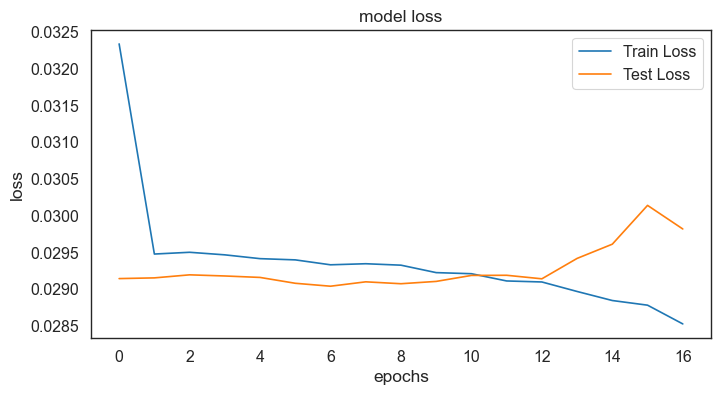

In [18]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán của chuỗi thời gian trên tập kiểm tra

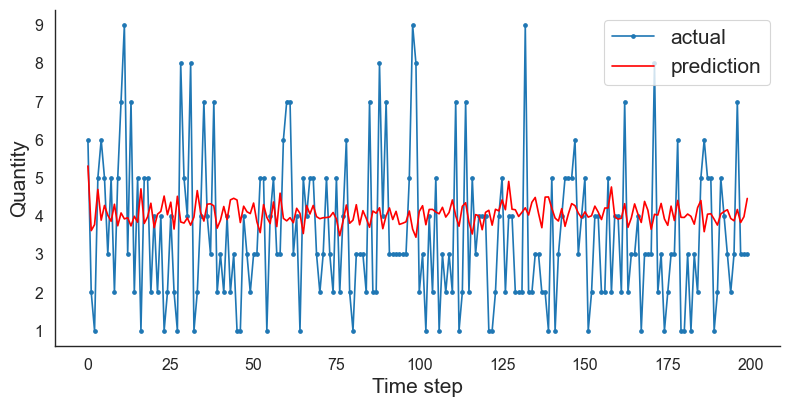

In [19]:
#Tạo một danh sách aa chứa các giá trị từ 0 đến 199.
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
#Vẽ đường cong các giá trị thực tế trên tập kiểm tra từ chỉ số 0 đến 199.
plt.plot(aa, y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Quantity', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();